<h1><center>ML DSL in Action</center></h1>

Google Cloud Platform: 
1. Google Dataproc
2. Google Cloud Storage
3. Google AI Platform

In [1]:
import com.griddynamics.dsl.ml.mldsl as mldsl
from com.griddynamics.dsl.ml.settings.profiles import PySparkJobProfile, AIProfile, DeployAIProfile
from com.griddynamics.dsl.ml.settings.description import Platform

import importlib
import os
from datetime import datetime
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

## Prepare Sequences from Original Text

### Text Sample

In [10]:
!head -n 20 dev/aclImdb/test/pos/0_10.txt

E0529 15:46:05.474034247    3336 backup_poller.cc:132]       Run client channel backup poller: {"created":"@1590767165.473908703","description":"pollset_work","file":"src/core/lib/iomgr/ev_epoll1_linux.cc","file_line":242,"referenced_errors":[{"created":"@1590767165.473898852","description":"Bad file descriptor","errno":9,"file":"src/core/lib/iomgr/ev_epoll1_linux.cc","file_line":730,"os_error":"Bad file descriptor","syscall":"epoll_wait"}]}
I went and saw this movie last night after being coaxed to by a few friends of mine. I'll admit that I was reluctant to see it because from what I knew of Ashton Kutcher he was only able to do comedy. I was wrong. Kutcher played the character of Jake Fischer very well, and Kevin Costner played Ben Randall with such professionalism. The sign of a good movie is that it can toy with our emotions. This one did exactly that. The entire theater (which was sold out) was overcome by laughter during the first half of the movie, and were moved to tears durin

### Tokenizer to Create Sequences 

### Execute Tokenizer on ML Platform

In [11]:
%py_script_open -n text_tokenizer.py -p demo/scripts -o dev

Temporary path: /home/jovyan/work/data/.mldsl/ml_text_tokenizer.py


In [13]:
platform = Platform.GCP
profile = PySparkJobProfile(root_path='demo/scripts',
                                  bucket='{name_of_bucket_on_GCP}',
                                  project='{name_of_project_on_GCP}',
                                  cluster='{name_of_cluster_on_GCP}',
                                  region='global',
                                  ai_region='us-central1-a',
                                  job_prefix='demo_job',
                                  job_async=False)
profile.args=profile.load_profile_data("demo/spark_job_args.json")
PySparkJobProfile.set('JobProfile', profile)

In [15]:
%py_data -n text_tokenizer.py -p JobProfile -pm $platform -o gs://ai4ops/mldsl/data

Parameters string = <<<-n ml_text_tokenizer.py -p JobProfile -pm 1 -o gs://ai4ops/mldsl/data>>>


Job with id demo_job_1590767199 was submitted to the cluster ai4ops
Job STATUS was set to PENDING at 2020-05-29 15:46:39
Job STATUS was set to SETUP_DONE at 2020-05-29 15:46:39
      Yarn APP ml_text_tokenizer.py with STATUS ACCEPTED has PROGRESS 0
      Yarn APP ml_text_tokenizer.py with STATUS RUNNING has PROGRESS 10
Job STATUS was set to RUNNING at 2020-05-29 15:46:39
      Yarn APP ml_text_tokenizer.py with STATUS FINISHED has PROGRESS 100
Job STATUS was set to DONE at 2020-05-29 16:25:10


<IPython.core.display.JSON object>

In [ ]:
#Use job_demo_job_1590767199 instance to browse job properties.
#job_demo_job_1590767199 = job_tracker['demo_job_1590767199']

### Reading logs of dataproc job

In [16]:
project_id = "{name_of_project_on_GCP}"

filters = """resource.type:cloud_dataproc_cluster
AND timestamp>2020-02-16
AND resource.labels.cluster_name:{name_of_cluster_on_GCP}
AND jsonPayload.application:application_1590766736446_0002"""

In [17]:
%logging -p $project_id -f $filters

05/29/2020, 15:46:49	Class path contains multiple SLF4J bindings.
05/29/2020, 15:46:49	Found binding in [jar:file:/usr/lib/spark/jars/slf4j-log4j12-1.7.16.jar!/org/slf4j/impl/StaticLoggerBinder.class]
05/29/2020, 15:46:49	Found binding in [jar:file:/usr/lib/hadoop/lib/slf4j-log4j12-1.7.25.jar!/org/slf4j/impl/StaticLoggerBinder.class]
05/29/2020, 15:46:49	See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
05/29/2020, 15:46:49	Actual binding is of type [org.slf4j.impl.Log4jLoggerFactory]
05/29/2020, 15:46:49	Setting up env variables
05/29/2020, 15:46:49	Setting up job resources
05/29/2020, 15:46:49	Launching container
05/29/2020, 15:46:50	Connecting to ResourceManager at ai4ops-m/10.128.15.216:8030
05/29/2020, 15:46:52	Setting up env variables
05/29/2020, 15:46:52	Setting up job resources
05/29/2020, 15:46:52	Launching container
05/29/2020, 15:46:52	Class path contains multiple SLF4J bindings.
05/29/2020, 15:46:52	Found binding in [jar:file:/usr/lib/spark/jars/slf4

# ML Model to Predict Positive or Negative Review

### Configure Additional Dependencies

### LSTM Train Script

Max sequence is set to 150
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 150, 50)           20000050  
_________________________________________________________________
lstm (LSTM)                  (None, 32)                10624     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 2)                 66        
_________________________________

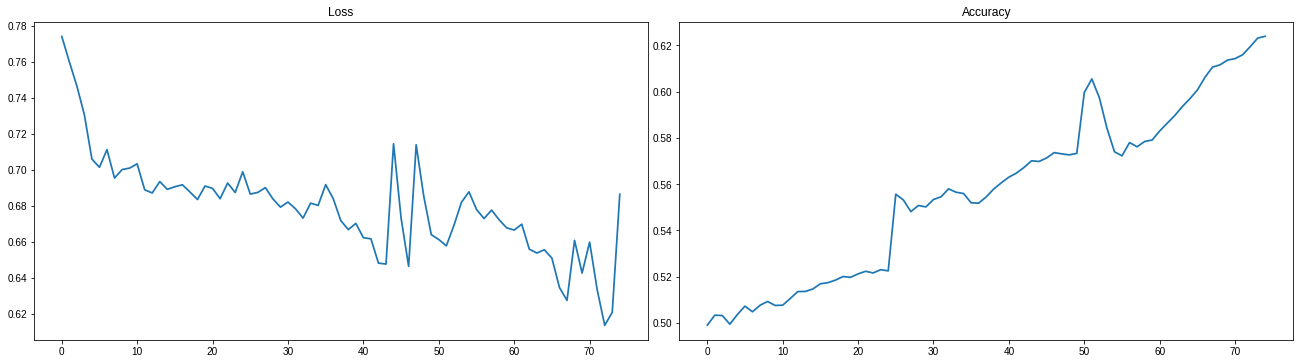

Temporary path: /home/jovyan/work/data/.mldsl/mr_model.py


In [2]:
%%py_script -e -n mr_model.py -p demo/model/words/trainer -o dev/models --epochs 3 --seq_len 150
#!/usr/bin/python

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    import pandas as pd
    import numpy as np
    from tensorflow.python.lib.io import file_io
    from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
    from tensorflow.keras.models import Model
    from tensorflow.keras.callbacks import Callback
    from tensorflow.keras.optimizers import Adam
    import tensorflow as tf
    import os

    from uuid import uuid4
    import argparse
    import matplotlib
    if matplotlib.get_backend() in ['TkAgg', 'TkCairo']:
        matplotlib.use('agg')
    import matplotlib.pyplot as plt
    import seaborn as sns

class MetricCallback(Callback):
    def on_train_begin(self,logs={}):
        self.losses = []
        self.accuracies = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accuracies.append(logs.get('acc'))


def read_glove_vectors(glove_file):
    files = file_io.get_matching_files('{}/part*'.format(glove_file))
    for file in files:
        with file_io.FileIO(file, 'r') as f:
            word_to_vec_map = {}
            words_to_index = {}
        fl = f.readline()
        for line in f:
            line = line.strip().split('\t')
            word_to_vec_map[line[0]] = np.array(line[1].split(','), dtype=np.float64)
            words_to_index[line[0]] = int(line[2])
    return words_to_index, word_to_vec_map


def read_csv(path):
    files = file_io.get_matching_files('{}/part*'.format(path))
    pdf = []
    for file in files:
        with file_io.FileIO(file, 'r') as f:
            df = pd.read_csv(f)
            if df is not None and len(df) != 0:
                pdf.append(df)
    if len(pdf) == 0:
        return None
    return pd.concat(pdf, axis=0, ignore_index=True).reset_index()


def pretrained_embed_layer(word_to_vec_map, word_to_index, emb_dim):
    emb_matrix = np.zeros((len(word_to_index)+1, emb_dim))
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]
    
    return emb_matrix


def define_model(input_shape, emb_matrix, vocab_len, emb_dim, rnn_units, dropout=0.5):
    sentence_indices = Input(input_shape, dtype="int32")
    # Create the embedding layer pretrained with GloVe Vectors
    embedding_layer = Embedding(input_dim=vocab_len, trainable=False, output_dim=emb_dim)
    embedding_layer.build((None,))
    embedding_layer.set_weights([emb_matrix])
    # Propagate sentence_indices through your embedding layer
    embeddings = embedding_layer(sentence_indices)
    X = LSTM(units=rnn_units, return_sequences=False)(embeddings)
    # Add dropout with a probability 
    X = Dropout(dropout)(X)
    # Propagate X through a Dense layer
    X = Dense(2)(X)
    # Add a softmax activation
    X = Activation("softmax")(X)
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=sentence_indices, outputs=X)
    return model


def convert_to_one_hot(Y, C=2):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

def prepare_dataset(path, N, word_to_index):
    data = read_csv(path)
    data.dropna(inplace=True)
    data['int_seq'] = data['int_seq'].apply(lambda x: [int(i) for i in x.split(',')])
    l = data['int_seq'].apply(lambda x: len(x))
    print("Max sequence is set to {}".format(N))
    data['int_seq'] = data['int_seq'].apply(lambda x: (x + [word_to_index["unk"]] * N)[:N])
    ds_x = np.asarray(list(data["int_seq"]))
    ds_y = data["class"].values
    return ds_x, ds_y, l


def plot_metrics(callback, dir_to_save):
    f, axes = plt.subplots(1, 2, figsize=(18, 5))
    plt.style.use('seaborn')
    plt.rcParams['axes.titlesize'] = 16
    sns.lineplot(x=range(len(callback.losses)), y=callback.losses, ax=axes[0])
    axes[0].title.set_text("Loss")
    sns.lineplot(x=range(len(callback.accuracies)), y=callback.accuracies, ax=axes[1])
    axes[1].title.set_text("Accuracy")
    plt.tight_layout(.5)
    plt.savefig('{}'.format(dir_to_save))
    plt.show()


if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--train_path', type=str, help="Train files path")
    parser.add_argument('--output_path', type=str, help="Models output path")
    parser.add_argument('--word_embeds', type=str, help="Models output path")
    parser.add_argument('--seq_len', type=int, help="Length of input sequence")
    parser.add_argument('--epochs', type=int, help="Number of epochs")
    args, d = parser.parse_known_args()

    word_to_index, word_to_vec_map = read_glove_vectors(args.word_embeds)
    N = args.seq_len
    train_x, train_y, l = prepare_dataset(args.train_path, N, word_to_index)
    train_y = convert_to_one_hot(train_y, C=2)
    NUM_EPOCS = args.epochs
    RNN_STATE_DIM = 32
    LEARNING_RATE = 0.01
    vocab_len = len(word_to_index) + 1
    emb_dim = word_to_vec_map["cucumber"].shape[0]
    emb_matrix = pretrained_embed_layer(word_to_vec_map, word_to_index, emb_dim)

    model = define_model((N, ), emb_matrix, vocab_len, emb_dim, RNN_STATE_DIM)
    print(model.summary())
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=LEARNING_RATE), metrics=['accuracy'])
    # fit model
    metrics = MetricCallback()
    a = model.fit(train_x, train_y, batch_size=1024, epochs=NUM_EPOCS, callbacks=[metrics], 
                  shuffle=True)

    tf.get_logger().setLevel('ERROR')
    # save the model to file
    local_dir = uuid4().hex
    file_io.recursive_create_dir(local_dir)
    local_path = f'{local_dir}/saved_model'
    tf.saved_model.save(model, local_path)
    local_path_chart = '{}/metrics.png'.format(local_dir)
    plot_metrics(metrics, local_path_chart)
    
    remote_dir = args.output_path
    remote_path = f'{remote_dir}/saved_model'
    remote_path_chart = f'{remote_dir}/metrics.png'
    if not remote_dir.startswith('gs://'):
        file_io.recursive_create_dir(remote_dir)
    file_io.copy(local_path_chart, remote_path_chart)
    tf.saved_model.save(model, remote_path)
    
    file_io.delete_recursively(local_dir)

In [8]:
platform = Platform.GCP
profile = AIProfile(bucket='{name_of_bucket_on_GCP}', cluster='{name_of_cluster_on_GCP}', region='global', job_prefix='train',
                    root_path='/demo/scripts', 
                    project='{name_of_project_on_GCP}',
                    ai_region='us-central1', job_async=False,
                    package_name='trainer', package_dst='mldsl/packages',
                    scale_tier='BASIC', runtime_version='1.15', python_version='3.7')
profile.arguments = profile.load_profile_data("demo/train_args.json")
AIProfile.set('AIProfile', profile)

running sdist
running egg_info
writing trainer.egg-info/PKG-INFO
writing dependency_links to trainer.egg-info/dependency_links.txt
writing requirements to trainer.egg-info/requires.txt
writing top-level names to trainer.egg-info/top_level.txt
reading manifest file 'trainer.egg-info/SOURCES.txt'
writing manifest file 'trainer.egg-info/SOURCES.txt'
running check
creating trainer-1.0
creating trainer-1.0/trainer
creating trainer-1.0/trainer.egg-info
copying files to trainer-1.0...
copying README.md -> trainer-1.0
copying setup.py -> trainer-1.0
copying trainer/__init__.py -> trainer-1.0/trainer
copying trainer/mr_model.py -> trainer-1.0/trainer
copying trainer.egg-info/PKG-INFO -> trainer-1.0/trainer.egg-info
copying trainer.egg-info/SOURCES.txt -> trainer-1.0/trainer.egg-info
copying trainer.egg-info/dependency_links.txt -> trainer-1.0/trainer.egg-info
copying trainer.egg-info/requires.txt -> trainer-1.0/trainer.egg-info
copying trainer.egg-info/top_level.txt -> trainer-1.0/trainer.egg-i

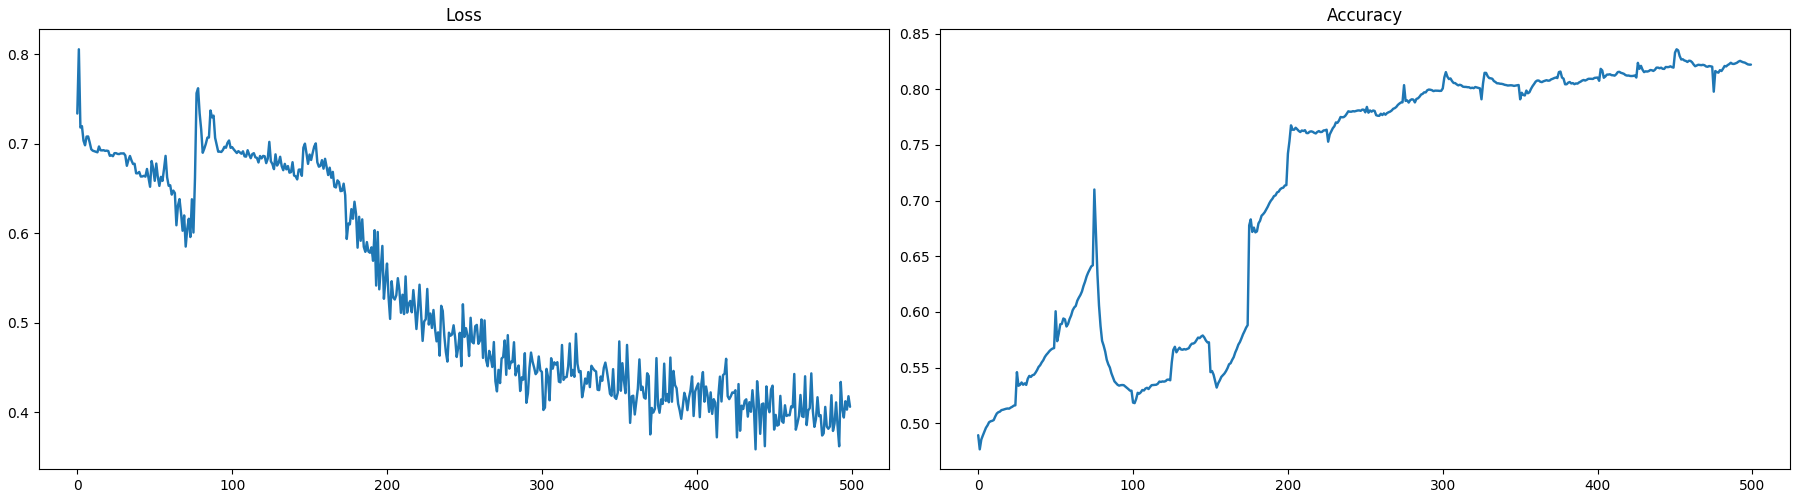

<IPython.core.display.JSON object>

In [9]:
%py_train -n mr_model.py -s demo/model/words -p AIProfile -pm $platform -o gs://{bucket}/mldsl

In [ ]:
#Use job_train_1591004612 instance to browse job properties.
#job_train_1591004612 = job_tracker['train_1591004612']

## Deployment of model

##### Parameters of deployment: name of model, version, artifacts (models saved as .joblib, .h5 etc), custom code

In [7]:
platform = Platform.GCP
profile = DeployAIProfile(bucket='{name_of_bucket_on_GCP}', cluster='{name_of_cluster_on_GCP}', region='global', 
                          job_prefix='deploy',
                          root_path='demo/deploy', 
                          project='{name_of_project_on_GCP}',
                          ai_region='us-central1', job_async=False,
                          package_name='', package_dst='staging',
                          scale_tier='BASIC', runtime_version='1.15', python_version='3.7',
                          model_name = 'mldsl', version_name='v1', is_new_model=False,
                          path_to_saved_model='gs://{bucket}/mldsl/train_1591004612/saved_model/')
profile.arguments = {
    "framework": "TENSORFLOW"
}
DeployAIProfile.set('AIProfile', profile)

In [8]:
%%py_script -n setup.py -p ./demo/deploy
#!/usr/bin/python

from setuptools import setup, find_packages
setup(
    name='predictor',
    version='1.0',
    author='Grid Dynamics ML Engineer',
    author_email='griddynamics@griddynamics.com',
    url='https://griddynamics.com',
)

Temporary path: /home/jovyan/work/data/.mldsl/setup.py


In [9]:
%py_deploy -n mldsl -p AIProfile -s demo/deploy  -pm $platform

running sdist
running egg_info
writing predictor.egg-info/PKG-INFO
writing dependency_links to predictor.egg-info/dependency_links.txt
writing top-level names to predictor.egg-info/top_level.txt
reading manifest file 'predictor.egg-info/SOURCES.txt'
writing manifest file 'predictor.egg-info/SOURCES.txt'
running check
creating predictor-1.0
creating predictor-1.0/predictor.egg-info
copying files to predictor-1.0...
copying README.md -> predictor-1.0
copying predictor.py -> predictor-1.0
copying setup.py -> predictor-1.0
copying predictor.egg-info/PKG-INFO -> predictor-1.0/predictor.egg-info
copying predictor.egg-info/SOURCES.txt -> predictor-1.0/predictor.egg-info
copying predictor.egg-info/dependency_links.txt -> predictor-1.0/predictor.egg-info
copying predictor.egg-info/top_level.txt -> predictor-1.0/predictor.egg-info
Writing predictor-1.0/setup.cfg
Creating tar archive
removing 'predictor-1.0' (and everything under it)
Uploading custom package demo/deploy/dist/predictor-1.0.tar.gz 

<IPython.core.display.JSON object>

In [ ]:
#Use job_deploy_1591005934_predictor instance to browse job properties.
#job_tracker['deploy_1591005934_predictor']

## Prediction

In [23]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    from utils import *

word_to_index, word_to_vec_map = read_glove_vectors("gs://{bucket}/mldsl/data/demo_job_1590767199/words")
df_x, df_y, l = prepare_dataset('gs://{bucket}/mldsl/data/demo_job_1590767199/train', 150, word_to_index)

Max sequence is set to 150


In [ ]:
ints = np.random.choice(len(df_y), 100)

test_x = df_x[ints]
test_y = df_y[ints]
test = test_x.tolist()

In [24]:
%py_test -p AIProfile -pm $platform -t $test

In [25]:
activation=[[0.0763, 0.9236], [0.7479, 0.2520], [0.1149, 0.8851], [0.9632, 0.0367], [0.9794, 0.0205], [0.1600, 0.8399], [0.0756, 0.9243], [0.9110, 0.0889], [0.6029, 0.3970584571361542], [0.14225800335407257, 0.8577420115470886], [0.06333357840776443, 0.9366663694381714], [0.9743743538856506, 0.025625616312026978], [0.9681770205497742, 0.03182300180196762], [0.03512100502848625, 0.964879035949707], [0.04376760870218277, 0.9562323689460754], [0.26621484756469727, 0.7337852120399475], [0.06679192185401917, 0.9332080483436584], [0.051758527755737305, 0.9482414722442627], [0.49746036529541016, 0.5025395750999451], [0.8411456942558289, 0.15885433554649353], [0.922367513179779, 0.07763243466615677], [0.9244933128356934, 0.0755067691206932], [0.5253538489341736, 0.4746461510658264], [0.7071253657341003, 0.29287463426589966], [0.27401697635650635, 0.7259830832481384], [0.9571094512939453, 0.042890556156635284], [0.5961024165153503, 0.4038976728916168], [0.5080382227897644, 0.4919617474079132], [0.9678243398666382, 0.03217558562755585], [0.021934354677796364, 0.9780656695365906], [0.7710021734237671, 0.22899776697158813], [0.5068738460540771, 0.49312618374824524], [0.0422273650765419, 0.9577726721763611], [0.03476165235042572, 0.9652382731437683], [0.967062771320343, 0.03293726593255997], [0.034166060388088226, 0.9658339619636536], [0.661314070224762, 0.3386859595775604], [0.3476886451244354, 0.652311384677887], [0.7019909620285034, 0.29800909757614136], [0.8247133493423462, 0.17528663575649261], [0.1573668122291565, 0.8426331877708435], [0.8963391780853271, 0.10366085171699524], [0.8273537755012512, 0.1726461946964264], [0.7638925313949585, 0.2361074835062027], [0.900901198387146, 0.099098801612854], [0.9743297696113586, 0.025670241564512253], [0.8769267201423645, 0.12307330965995789], [0.8166378736495972, 0.18336212635040283], [0.463306188583374, 0.536693811416626], [0.4359602928161621, 0.5640397667884827], [0.5380293130874634, 0.461970716714859], [0.9322284460067749, 0.0677715539932251], [0.015885164961218834, 0.9841148853302002], [0.015447582118213177, 0.9845523834228516], [0.32493576407432556, 0.675064206123352], [0.24269424378871918, 0.7573058009147644], [0.03912725672125816, 0.9608727097511292], [0.9620856046676636, 0.0379144586622715], [0.3279300928115845, 0.6720698475837708], [0.22086356580257416, 0.7791364192962646], [0.979588508605957, 0.02041146717965603], [0.018100405111908913, 0.981899619102478], [0.9595947861671448, 0.04040520638227463], [0.031090833246707916, 0.9689091444015503], [0.0270834993571043, 0.9729165434837341], [0.02446497417986393, 0.9755350351333618], [0.31624892354011536, 0.683751106262207], [0.9466636180877686, 0.053336307406425476], [0.9621150493621826, 0.03788500651717186], [0.9578911066055298, 0.04210885986685753], [0.10958409309387207, 0.8904159069061279], [0.27653148770332336, 0.7234686017036438], [0.9519773125648499, 0.04802265390753746], [0.837381899356842, 0.16261810064315796], [0.9448645710945129, 0.055135395377874374], [0.4114502966403961, 0.5885497331619263], [0.1889467090368271, 0.8110532760620117], [0.4810349941253662, 0.5189650058746338], [0.966179370880127, 0.03382059186697006], [0.8989152908325195, 0.10108472406864166], [0.06208815425634384, 0.937911868095398], [0.34143736958503723, 0.6585626006126404], [0.30845364928245544, 0.6915463805198669], [0.6908578276634216, 0.309142142534256], [0.9637742042541504, 0.03622574731707573], [0.7071535587310791, 0.2928463816642761], [0.1965351402759552, 0.8034648895263672], [0.9730255603790283, 0.02697441168129444], [0.18395622074604034, 0.8160437941551208], [0.8521286845207214, 0.14787133038043976], [0.13567009568214417, 0.8643299341201782], [0.675934910774231, 0.32406508922576904], [0.9746203422546387, 0.025379672646522522], [0.2150145173072815, 0.7849855422973633], [0.9751496911048889, 0.024850372225046158], [0.6916557550430298, 0.3083442449569702], [0.9558643102645874, 0.044135682284832], [0.9390143752098083, 0.060985635966062546], [0.9467990398406982, 0.05320099741220474], [0.8948332667350769, 0.10516678541898727]]

In [26]:
dense=np.array(activation).argmax(axis=1)

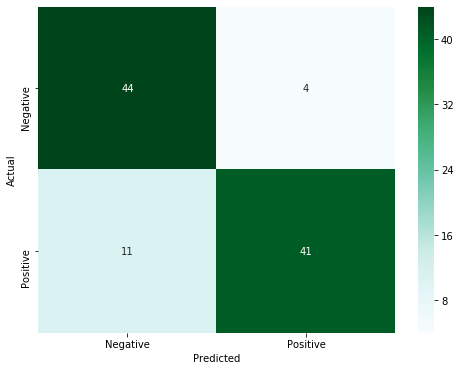

In [27]:
conf_mat = confusion_matrix(test_y, dense)
fig, ax = plt.subplots(figsize=(8,6))
classes=['Negative', 'Positive']
sns.heatmap(conf_mat, annot=True, fmt='d',xticklabels=classes, yticklabels=classes, cmap=plt.cm.BuGn)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [28]:
target_names = ['negative review', 'positive review']
print(classification_report(test_y, dense, target_names=target_names))

                 precision    recall  f1-score   support

negative review       0.80      0.92      0.85        48
positive review       0.91      0.79      0.85        52

       accuracy                           0.85       100
      macro avg       0.86      0.85      0.85       100
   weighted avg       0.86      0.85      0.85       100

